In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
import cv2
from functools import partial
import torch.nn as nn

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = models.vgg19(pretrained = True).features
for params in model.parameters():
  params.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
for name, layer in enumerate(model):
    if isinstance(layer, nn.MaxPool2d):
        model[name] = nn.AvgPool2d(kernel_size=layer.kernel_size, stride = layer.stride)

In [5]:
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (19): Conv2d(256

In [0]:
def get_image(path_1, path_2, size = 500):
    c_img = cv2.imread(path_1)
    #c_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB)
    c_img = np.random.randint(250, 256, size = c_img.shape, dtype=np.uint8)
    s_img = cv2.imread(path_2)
    s_img = cv2.cvtColor(s_img, cv2.COLOR_BGR2RGB)
    
    c_max = max(c_img.shape)    
    if c_max > size:
        size = size
    else:
        size = c_max
        
    transform_c = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((size)),
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    
    transform_s = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    
    c_img = transform_c(c_img).unsqueeze(0)
    s_img = cv2.resize(s_img, (c_img.size()[3], c_img.size()[2]))
    s_img = transform_s(s_img).unsqueeze(0)
    return c_img.to(device), s_img.to(device)

In [0]:
def img_conv(image):
    image = image.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1,2,0)
    mean = np.array((0.485, 0.456, 0.406), dtype = np.float16)
    std = np.array((0.229, 0.224, 0.225), dtype = np.float16)
    # mean = np.array((0.485, 0.456, 0.406), dtype = np.float16)[:, np.newaxis, np.newaxis]
    # std = np.array((0.229, 0.224, 0.225), dtype = np.float16)[:, np.newaxis, np.newaxis]
    image = (image * std) + mean
    # image = image.transpose(1,2,0)
    image = image.clip(0,1)
    return image

In [0]:
content, style = get_image('pic_5.jpg','pic_0.jpg')

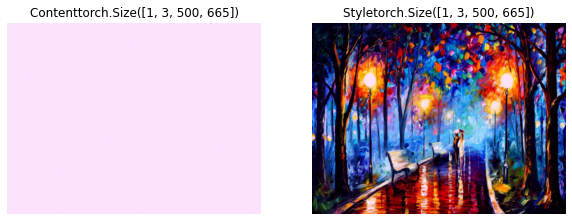

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img_conv(content))
ax[0].set_title("Content"+str(content.size()))
ax[0].axis(False)
ax[1].imshow(img_conv(style))
ax[1].set_title("Style"+str(style.size()))
ax[1].axis(False)
plt.show()

In [0]:
def get_features(mod, image):
  layers = ['0','5', '10', '19', '21', '28']
  fm = {}
  def hook(module, input, output, key):
    fm[key] = output

  for name, layer in mod._modules.items():
    if name in layers:
      handle = layer.register_forward_hook(partial(hook, key = name))
      output = mod(image)
      handle.remove()
  return fm

In [0]:
gen_image = torch.randn(content.shape).to(device)
target = content.clone().requires_grad_(True)

In [0]:
cf = get_features(model, content)
sf = get_features(model, style)

In [0]:
def get_gram(gm): #input = [N, D, H, W]
    n, d, w, h = gm.size()
    reS = gm.view(n*d, w*h)
    gram_matrix = torch.mm(reS, reS.t())
    return gram_matrix, (d, h, w)

In [0]:
style_weights = {"0" : 0.99, "5" : 0.7, "10" : 0.6, "19": 1/6, "21": 1/6, "28":1/6}
content_weight = 1
style_weight = 1e6

In [0]:
style_gram = {l: get_gram(sf[l]) for l in style_weights}

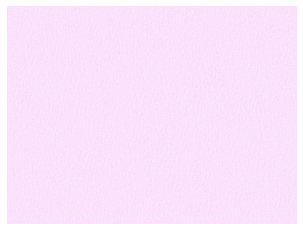

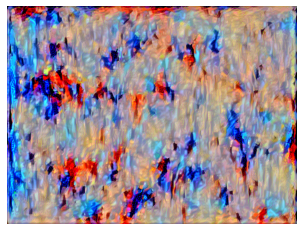

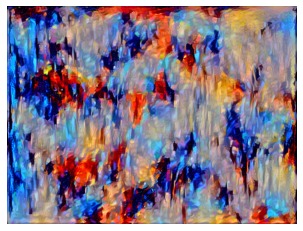

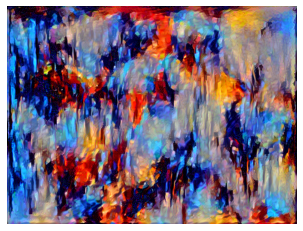

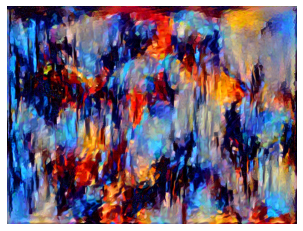

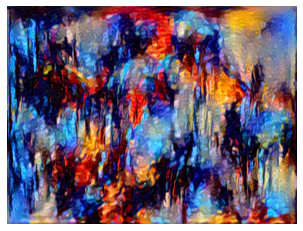

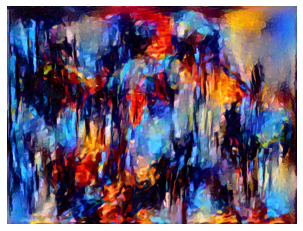

In [16]:
opt = torch.optim.Adam([target], lr =.1)
epochs = 2100
for e in range(epochs):
    tf = get_features(model, target)
    c_loss = torch.mean((tf['21']-cf['21'])**2)
    s_loss = 0
    for key in style_weights:
        tar_gram, denom = get_gram(tf[key])
        s_loss += style_weights[key] * (torch.mean((tar_gram - style_gram[key][0])**2))/(denom[0]**2 *(denom[1]*denom[2])**2 * 4)
    total_loss = (content_weight * c_loss) + (style_weight * s_loss)
    opt.zero_grad()
    total_loss.backward()
    opt.step()
    if e%300==0:
        plt.imshow(img_conv(target))
        plt.axis(False)
        plt.show()

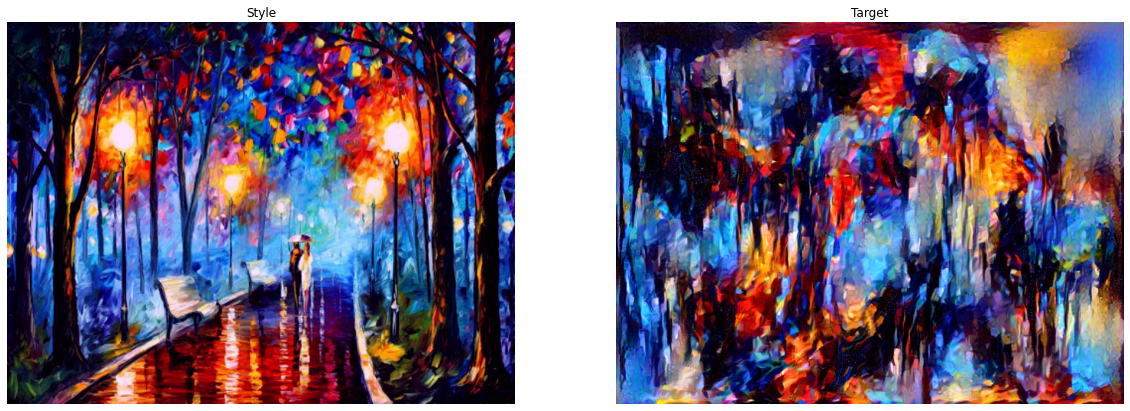

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,15))
ax[0].imshow(img_conv(style))
ax[0].set_title("Style")
ax[0].axis(False)
ax[1].imshow(img_conv(target))
ax[1].set_title("Target")
ax[1].axis(False)
plt.show()